In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
from tqdm import tqdm
from arch import arch_model

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.4f}'.format

In [5]:
df = yf.download(tickers=["RB=F"],period="10y",interval="1d",auto_adjust=True).reset_index()

[*********************100%***********************]  1 of 1 completed


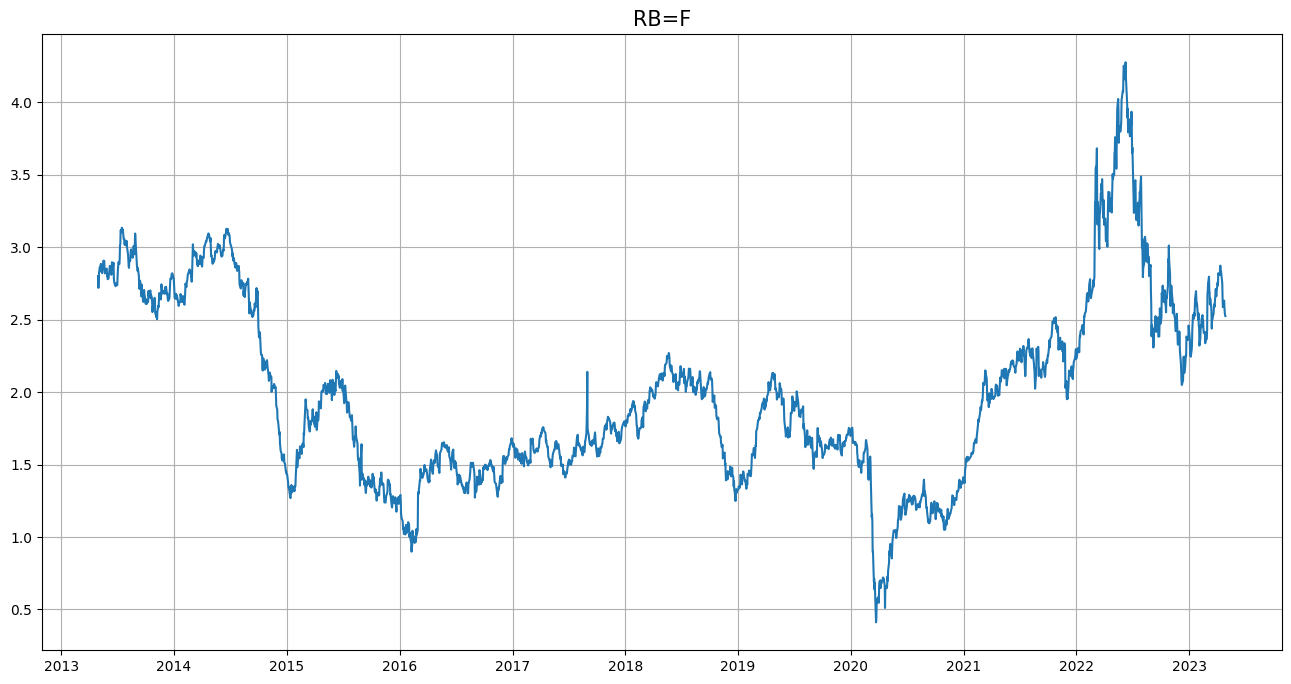

In [6]:
plt.figure(figsize=(16,8))
plt.title("RB=F", fontsize=15)
plt.plot(df["Date"], df["Close"])
plt.grid()
plt.show()

# Simple Strategy based on seasonality
- buy at mid April and Sell at June

In [7]:
def simple_seasonaility(x):
    start = (1,7)
    end = (5,20)    
    
    date = x["Date"]
    date = datetime(year=date.year,month=date.month,day=date.day)
    
    start_date = datetime(year=date.year,month=start[0],day=start[1])
    end_date = datetime(year=date.year,month=end[0],day=end[1])
    
    if date >= start_date and date <= end_date:
        return 1
    else:
        return 0    

df["position"] = df.apply(lambda x: simple_seasonaility(x),axis=1)
df["position_singal"] = df["position"] - df["position"].shift(1)
df["daily_chg"] = df["Close"] - df["Close"].shift(1)
df["daily_chg%"] = df["daily_chg"] / df["Close"].shift(1)

# we assume buy and sell at close price of the day, so the day when we buy, there should be no pnl
df["portfolio_return"] = (1+df["daily_chg%"] * (df["position"]==1) * (df["position_singal"]<1))
df["cum_return"] = df["portfolio_return"].cumprod()
df["year"] = df["Date"].apply(lambda x: x.year)

df_agg = df.copy()
df_agg = df_agg[df_agg["position"] > 0]
df_agg["open_price"] = df_agg["close_price"] = df_agg["Close"]
df_agg = df_agg.groupby(["year"]).agg({
    "portfolio_return": "prod",
    "open_price": "first",
    "close_price": "last",
})

#df_agg = df.groupby(["year"]).prod()[["portfolio_return"]]
df_agg["gain_or_loss"] = df_agg["portfolio_return"].apply(lambda x: "Gain" if x > 1 else "Loss")
df_agg["win_rate"] = df_agg["portfolio_return"].apply(lambda x: 1 if x > 1 else 0) 
df_agg["return_derv_from_open_close"] = (df_agg["close_price"] - df_agg["open_price"])/df_agg["open_price"] + 1
df_agg["pnl_per_1_contracts"] = df_agg["open_price"] * (df_agg["portfolio_return"]-1) * 42000

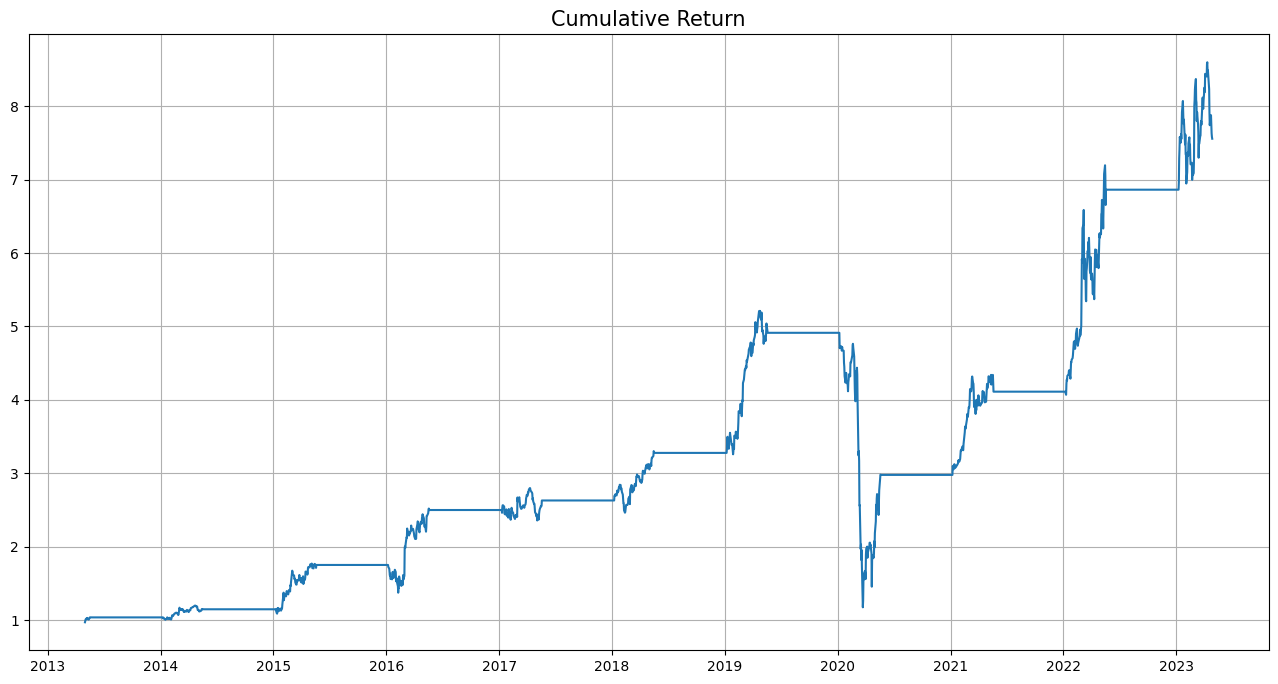

,portfolio_return,open_price,close_price,gain_or_loss,win_rate,return_derv_from_open_close,pnl_per_1_contracts
year,,,,,,,
2013,1.0374,2.8009,2.9056,Gain,1,1.0374,"4,397.4037"
2014,1.1065,2.6786,2.9640,Gain,1,1.1065,"11,986.7964"
2015,1.5259,1.3376,2.0411,Gain,1,1.5259,"29,547.0014"
2016,1.4272,1.1460,1.6356,Gain,1,1.4272,"20,563.1976"
2017,1.0520,1.5707,1.6523,Gain,1,1.0520,"3,427.1979"
2018,1.2464,1.7918,2.2333,Gain,1,1.2464,"18,542.9978"
2019,1.4990,1.3408,2.0099,Gain,1,1.4990,"28,102.2019"
2020,0.6061,1.7222,1.0438,Loss,0,0.6061,"-28,492.8017"
2021,1.3807,1.4827,2.0472,Gain,1,1.3807,"23,708.9989"


win rate: 90.9%
average return: 24.1%


In [10]:
plt.figure(figsize=(16,8))
plt.title("Cumulative Return", fontsize=15)
plt.plot(df["Date"], df["cum_return"])
plt.grid()
plt.show()
display(df_agg)

print("win rate: {:.1f}%".format(100*df_agg.sum()["win_rate"]/len(df_agg)))
print("average return: {:.1f}%".format(100*(df_agg["portfolio_return"].mean()-1)))

# Optimize the strategy via entry and exit dates
- Try to find the best entry and exit due to summer seasonality

1. Restruct the input data into a <b>close-daily-return matrix</b> with size of <b>(number of days, years)</b>
2. Use brute force solution to iterate every possible entry and exit dates
3. Find the entry and exit dates which maximize the cumulative returns over the defined historical periods (~10years)

In [11]:
df_m = df.copy()
df_m = df_m[["Date", "year", "daily_chg%"]]
df_m["daily_chg%"] += 1
df_m["day"] = df_m["Date"].apply(lambda x: x.date() - datetime(year=x.date().year, month=1, day=1).date())
df_m = pd.pivot_table(df_m,values=["daily_chg%"],index="day",columns="year", fill_value=1)
m = df_m.values
dates = df_m.reset_index()["day"]

In [12]:
l,n = np.shape(m)
max_r = -1
max_args = (-1,-1)

for i in range(l):
    for j in range(i+1,l):       
        X = np.ones((j-i,n))                
        m_ = m[i+1:j+1]        
        r = np.prod(X*m_)        
        if r > max_r:
            max_r = r
            max_args = (i,j)            

In [13]:
start_date = (datetime(year=datetime.today().year,month=1,day=1) + timedelta(max_args[0])).strftime("%Y-%m-%d")
end_date = (datetime(year=datetime.today().year,month=1,day=1) + timedelta(max_args[1])).strftime("%Y-%m-%d")

print("max_cum_return: {}".format(max_r))
print("entry date: {}".format(start_date))
print("exit date : {}".format(end_date))

max_cum_return: 7.76019492826212
entry date: 2023-01-07
exit date : 2023-05-20
